In [1]:
import torch
import spacy
from transformers import pipeline
from dotenv import load_dotenv
import os

load_dotenv()

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import os

class DocumentsStore:
    def __init__(self, pickle_df_path: str, chunk_size: int = 512, chunk_overlap: int = 50, embeddings_pickle_path: str = None):
        self.__df = pd.read_pickle(pickle_df_path)
        self.__df = self.__df.reset_index(drop=True)
        self.__embeddings = None
        self.__chunks: list[str] = []
        self.__chunks_ids: list[int] = []
        self.__chunk_size = chunk_size
        self.__chunk_overlap = chunk_overlap
        self.__pickle_df_path = pickle_df_path
        self.__embeddings_pickle_path = embeddings_pickle_path
        self.__generate_embeddings()

    @property
    def df(self):
        return self.__df

    @property
    def embeddings(self):
        return self.__embeddings

    @property
    def chunks(self):
        return self.__chunks

    @property
    def chunks_ids(self):
        return self.__chunks_ids
    
    @property
    def chunk_size(self):
        return self.__chunk_size
    
    @property
    def chunk_overlap(self):
        return self.__chunk_overlap

    def __create_chunks(self) -> None:
        text_splitter = TokenTextSplitter(
            chunk_size=self.__chunk_size,
            chunk_overlap=self.__chunk_overlap
        )

        try:
            for i, r in self.__df.iterrows():
                new_chunks = text_splitter.split_text(r["Text"])
                self.__chunks.extend(new_chunks)
                self.__chunks_ids.extend([i] * len(new_chunks))
            
            logging.info('Chunking finished')
        except Exception as e:
            logging.error(f"Error during chunking: {e}")
            raise e

    def __generate_embeddings(self):
        self.__create_chunks()

        if self.__embeddings_pickle_path and os.path.exists(self.__embeddings_pickle_path):
            try:
                with open(self.__embeddings_pickle_path, 'rb') as f:
                    self.__embeddings = pickle.load(f)
                logger.info('Embeddings loaded from pickle')
                return
            except Exception as e:
                logger.error(f"Error loading embeddings from pickle: {e}")
        
        if len(self.__chunks) == 0:
            logging.warning('No chunks to process')
            return

        model = SentenceTransformer("nomic-ai/nomic-embed-text-v2-moe", trust_remote_code=True)
        
        pool = model.start_multi_process_pool()
        self.__embeddings = model.encode_multi_process(
            self.__chunks,
            pool,
            prompt_name="passage"
        )
        model.stop_multi_process_pool(pool)

        # Save embeddings to disk
        try:
            with open('store-embeddings-nomic.pkl', 'wb') as f:
                pickle.dump(self.__embeddings, f)
        except Exception as e:
            logging.error(f"Error saving embeddings: {e}")

        logging.info('Embeddings generated')
    
    def chunk_text_from_id(self, id: int) -> str | None:
        if id < 0 or id >= len(self.__chunks):
            return None
        return self.__chunks[id]

    def document_text_from_chunk_id(self, chunk_id: int) -> str | None:
        if chunk_id < 0 or chunk_id >= len(self.__chunks_ids):
            return None
        return self.__df.iloc[self.__chunks_ids[chunk_id]]["Text"]

    def save_to_pickle(self, file_name: str) -> None:
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(self, f)
        except Exception as e:
            logging.error(f"Error saving to pickle: {e}")
            raise e
    
    @staticmethod
    def load_from_pickle(file_name: str) -> 'DocumentsStore':
        try:
            with open(file_name, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            logging.error(f"Error loading from pickle: {e}")
            raise e


In [3]:
import pickle
store = DocumentsStore.load_from_pickle("store-better-preprocess.pkl")
store.df

,Path,Text
0,pack\AIBR\2006-Aymaras-peruanos-y-chilenos-en-...,introducción el presidente recibió el siguient...
1,pack\AIBR\2006-Cambios-de-género-y-discriminac...,introducción e l presente artículo es producto...
2,pack\AIBR\2006-Consecuencias-personales-en-la-...,introducción e l propósito al iniciar este tra...
3,pack\AIBR\2006-Construcción-de-modelos-de-géne...,introducción todos somos conscientes de que pe...
4,pack\AIBR\2006-Contribuciones-feministas-a-pro...,omo señala dileonardo a comienzos de la década...
...,...,...
1906,pack\Revista-Española-de-Antropología-American...,1. introducción. 2. paridad de género en presi...
1907,pack\Revista-Española-de-Antropología-American...,1. introducción. 2. baja california: escenario...
1908,pack\Revista-Española-de-Antropología-American...,1. introducción. 2. los signos de quipus. 3. l...
1909,pack\Revista-Española-de-Antropología-American...,1. introducción. 2. el inicio de la desigualda...


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('preprocessed.csv')
import pickle
chunks, chunks_ids = store.chunks, store.chunks_ids
import bisect

def find_index_range(chunks_ids, target):
    start_index = bisect.bisect_left(chunks_ids, target)
    end_index = bisect.bisect_right(chunks_ids, target) - 1
    
    if start_index == len(chunks_ids) or chunks_ids[start_index] != target:
        return None  # El índice no se encontró en la lista
    return (start_index, end_index)

# Función para obtener los chunks de un documento target
def get_chunks(target):
    """
    Obtiene los chunks de un documento específico.

    Args:
        target (int): El ID del documento del cual se quieren obtener los chunks.

    Returns:
        list: Una lista de chunks correspondientes al documento target.
    """
    test_indices = find_index_range(chunks_ids, target)
    return chunks[test_indices[0]:test_indices[1]]

NameError: name 'store' is not defined

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
import torch
# Crear embeddings y almacenarlos
def get_embeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"):
    return HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs={"device": "cuda" if torch.cuda.is_available() else "cpu"}
    )

In [6]:
from langchain_community.vectorstores import FAISS
def get_db(testing_chunks, embeddings):
    return FAISS.from_texts(
        texts=testing_chunks,
        embedding=embeddings
    )

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import HuggingFacePipeline
def get_llm(model_id = "meta-llama/Llama-3.2-1B-Instruct", tokenizer_id = "meta-llama/Llama-3.2-1B-Instruct"):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )

    # Crear pipeline para utilizar con LangChain
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        temperature=0.1,
        return_full_text=False,
        do_sample=True
    )
    return HuggingFacePipeline(pipeline=pipe)

In [ ]:
from langchain.chains import RetrievalQA
def get_qa_chain(llm, db):
    return RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=db.as_retriever(search_kwargs={"k": 3})
    )

: 

In [ ]:
llm = get_llm("meta-llama/Llama-3.2-3B-Instruct", "meta-llama/Llama-3.2-3B-Instruct")

Loading checkpoint shards:  50%|█████     | 1/2 [00:14<00:14, 14.84s/it]

In [ ]:

def build_qa_chain_for_target(target, llm_model_id = "meta-llama/Llama-3.2-1B-Instruct", tokenizer_model_id = "meta-llama/Llama-3.2-1B-Instruct", embeddings_model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"):
    testing_chunks = get_chunks(target)
    embeddings = get_embeddings(embeddings_model_id)
    db = get_db(testing_chunks, embeddings)
    
    return get_qa_chain(llm, db)

In [ ]:
# qa_chain = build_qa_chain_for_target(340)

In [ ]:
# qa_chain.invoke("¿Qué motivo a la creación de los nuevos consulados indianos?")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'query': '¿Qué motivo a la creación de los nuevos consulados indianos?',
 'result': ' La creación de los nuevos consulados indianos fue motivada por la necesidad de conseguir un pacto político regional con los comerciantes americanos establecidos en regiones estratégicas, y por la creencia de que los consulados, como instituciones mercantiles, podrían actuar como aliados de la causa realista.'}

In [ ]:
# df = pd.read_csv('preprocessed.csv')
df

NameError: name 'pd' is not defined

In [ ]:
# store.df

NameError: name 'store' is not defined

In [ ]:
lista = [340, 341, 372, 1226, 1151, 1649, 1668, 1733, 1685, 1637]
lista2 = [340, 341, 372, 1219, 1144, 1649, 1668-9, 1733-9, 1685-9, 1637-9]

pregunta = [
    "¿Qué motivo a la creación de los nuevos consulados indianos?",
    "¿Cómo influyó el crédito mercantil en la economía y la dinámica comercial de Salta a fines del siglo XVIII?",
    "¿Cómo influyó la censura española en el desarrollo del mercado editorial cubano durante el siglo XIX?",
    "¿Cuáles son las claves historiográficas propopuestas para entender la cultura escrita en el Mundo Atlántico colonial, específicamente en Brasil y América del Norte?",
    "¿Qué papel desempeñaron los jesuitas en las ceremonias de coronación de Fernando VI y las exequias de Felipe V en las islas Marianas en 1747?",	
    "¿Cuál es el objetivo principal del artículo sobre la realeza sagrada en el antiguo Michoacán?",
    "¿Cómo se vinculan los objetos de rango prehispánicos con la identidad y el poder de la nobleza nahua colonial?",
    "De qué manera la modernidad transforma las narrativas indígenas sobre el pasado en los Andes bolivianos?",
    "¿Qué diferencias existen entre las descripciones de los instrumentos de observación solar incaicos?",
    "¿Cómo se relaciona el ramadero con la fertilidad en Chumbivilcas?"
]
for i, j in enumerate(lista):
    # print(df.iloc[lista[i]]['Path'])
    print(store.df.iloc[lista2[i]]['Path'])
    # print("----------")

pack\Anuario-de-Estudios-Americanos\1996-El-Consulado-en-el-proceso-de-independencia-de-Cartagena-de-Indias.pdf
pack\Anuario-de-Estudios-Americanos\1996-El-crédito-mercantil-Salta-a-fines-del-siglo-XVIII.pdf
pack\Anuario-de-Estudios-Americanos\1998-Aproximación-a-la-historia-del-imperialismo-editorial-de-Estados-Unidos-en-la-etapa-preindependentis.pdf
pack\Revista-de-Indias\2013-La-cultura-escrita-en-el-Mundo-Atlántico-colonial-Brasil-y-América-del-norte-Claves-historiográficas.pdf
pack\Revista-de-Indias\2010-El-Fénix-en-las-Marianas-1747.pdf
pack\Revista-Española-de-Antropología-Americana\2011-La-arqueología-patagónica-y-la-reconstrucción-de-la-historia-indígena.pdf
pack\Revista-Española-de-Antropología-Americana\2011-Supervivencia-de-los-objetos-de-rango-prehispánicos-entre-la-nobleza-colonial-nahua.pdf
pack\Revista-Española-de-Antropología-Americana\2015-Etnografías-del-pasado-en-los-Andes-bolivianos.pdf
pack\Revista-Española-de-Antropología-Americana\2012-Los-incas-y-el-Sol-métodos

In [ ]:
def tester(target, question):
    qa_chain = build_qa_chain_for_target(target)
    return qa_chain.invoke(question)

In [ ]:
for i in range(len(lista)):
    print(tester(lista2[i], pregunta[i])['result'])
    print("-----------------------------------")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 La creación de los nuevos consulados indianos fue motivada por la necesidad de establecer un pacto político regional con los comerciantes americanos, para evitar la aparición de peligrosos vacíos de poder o tentaciones rupturistas. La respuesta correcta es: la creación de los nuevos consulados indianos fue motivada por la necesidad de establecer un pacto político regional con los comerciantes americanos, para evitar la aparición de peligrosos vacíos de poder o tentaciones rupturistas.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 El crédito mercantil en Salta fue una herramienta importante para el desarrollo económico y comercial de la ciudad, ya que permitió a los comerciantes y mineros obtener préstamos en efectivo para financiar sus operaciones y proyectos. El crédito mercantil en Salta se centró en la venta de productos regionales, como el ganado mular, y en la exportación de productos de la región, como el sebo y el jabón. El crédito mercantil también permitió a los comerciantes y mineros invertir en sus propiedades y proyectos, lo que ayudó a impulsar el crecimiento económico de la ciudad. Sin embargo, el crédito mercantil también tenía sus limitaciones y desafíos, como la falta de liquidez y la volatilidad del mercado. En resumen, el crédito mercantil en Salta fue una herramienta importante para el desarrollo económico y comercial de la ciudad, pero también tenía sus limitaciones y desafíos.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 La censura española tuvo un impacto significativo en el desarrollo del mercado editorial cubano durante el siglo XIX. La censura española limitó la libertad de expresión y la libertad de impreso, lo que llevó a una reducción en la cantidad de publicaciones que se publicaban en español. La censura también impidió la publicación de obras que no estaban de acuerdo con las políticas españolas, lo que llevó a una mayor concentración de la producción editorial en torno a temas que reflejaban la opinión española. La censura también limitó la libertad de impreso, lo que llevó a una reducción en la cantidad de publicaciones que se publicaban en español. La censura también impidió la publicación de obras que no estaban de acuerdo con las políticas españolas, lo que llevó a una mayor concentración de la producción editorial en torno a temas que reflejaban la opinión española. La censura también limitó la libertad de impreso, lo que llevó a una reducción en la cantidad de publicaciones que se pub

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 Sugirió que las claves historiográficas para entender la cultura escrita en el Mundo Atlántico colonial, específicamente en Brasil y América del Norte, son:

1. La categoría flexible y la cultura escrita como una forma de identidad cultural.
2. El binomio letrados-iletrados y sus circunstancias y significados.
3. La república de las letras original en Norteamérica y su proceso de formación.
4. El ámbito local frente al nacional y la supuesta mayor libertad de acción, expresión y pensamiento en América del Norte.
5. La historia americana del libro y de la cultura escrita en general, que no es un campo de investigación muy cultivado en los Estados Unidos.
6. La libertad e independencia de los agentes del libro en las posesiones españolas y portuguesas.
7. El modelo de historia total del libro, con visión de futuro y superar los escollos antes comentados.
8. La marginación de espacios ibéricos, franceses y holandeses en el mundo atlántico.
9. La naturaleza y trayectoria histórica del Mun

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 Los jesuitas desempeñaron un papel importante en las ceremonias de coronación de Fernando VI y las exequias de Felipe V en las islas Marianas en 1747.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 The article appears to be an analysis of the social and economic structures of the pre-Columbian elite in the region of Michoacán, Mexico, and how they maintained their power and privilege through the concentration of wealth, the leadership of hereditary caciques, and the distribution of privileges.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 Los objetos de rango prehispánicos, como las insignias, armas y vestimenta, se utilizaban para identificar y confirmar la posesión de ciertos títulos y cargos prehispánicos, como tlatoani, y para asociar la nobleza con ciertos atributos prehispánicos. Estos objetos se utilizaban para revalidar la legitimidad del poder y para transmitir la herencia de los antepasados. La presencia de estos objetos en la vida cotidiana de la nobleza colonial sugiere que la nobleza nahua estaba comprometida con la conservación de la tradición prehispánica y la identidad de su estatus. La utilización de objetos de rango prehispánicos también sugiere que la nobleza colonial estaba dispuesta a reconocer y respetar la autoridad y el poder de los antepasados, incluso en un contexto colonial.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 The modernity transforms the narratives indígenas over the past in the Andes bolivianos by changing the way they perceive and interpret their past, and by incorporating new forms of modernity into their understanding of the past.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 No, there are no differences between the descriptions of the instruments of observation solar incaicos.
-----------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 El ramadero de pacapausa se relaciona con la fertilidad en Chumbivilcas de la siguiente manera: 

- El ramadero está ubicado en el centro de un corral, lo que sugiere que su función es proteger y cuidar al ganado.
- El ramadero tiene una morfología fálica característica, con un pene de piedra, lo que sugiere su dimensión fecundadora.
- El ramadero se entierra en el corral, lo que sugiere que su función es proteger y cuidar al ganado, y que su presencia es necesaria para garantizar la fertilidad del ganado.
- El ramadero se entierra en los corrales, lo que sugiere que su función es proteger y cuidar al ganado, y que su presencia es necesaria para garantizar la fertilidad del ganado.
- El ramadero se entierra en los corrales, lo que sugiere que su función es proteger y cuidar al ganado, y que su presencia es necesaria para garantizar la fertilidad del ganado.
- El ramadero se entierra en los corrales, lo que sugiere que su función es proteger y cuidar al ganado, y que su presencia es ne

: 

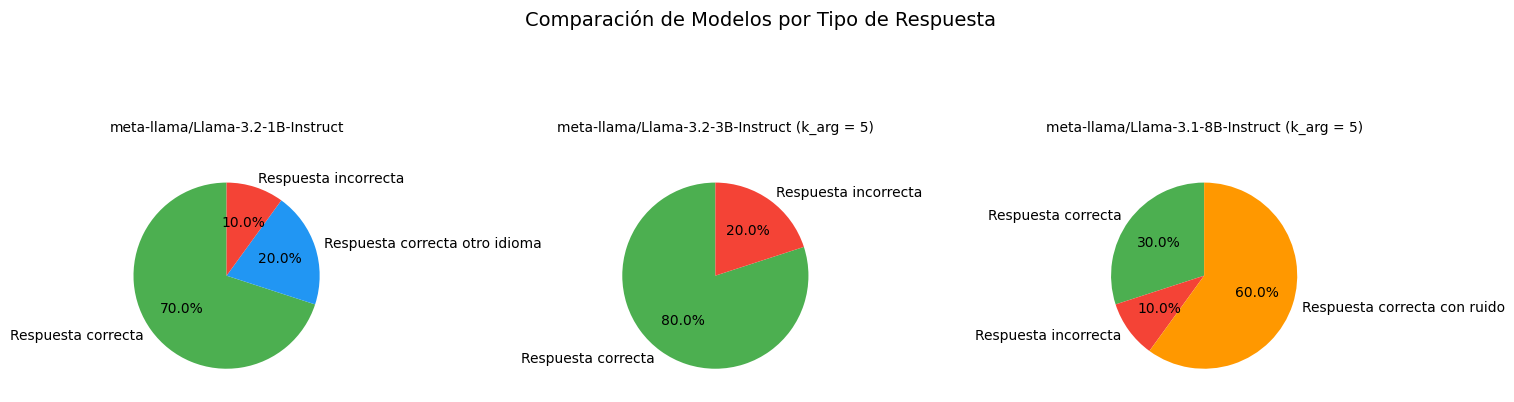

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_performance(models, success, success_other_lang, error, success_noise):
    # Colores para cada categoría
    colors = ['#4CAF50', '#2196F3', '#F44336', '#FF9800']  # Verde, Azul, Rojo, Naranja
    labels = ['Respuesta correcta', 'Respuesta correcta otro idioma', 'Respuesta incorrecta', 'Respuesta correcta con ruido']
    
    # Crear una figura con subplots (uno por modelo)
    fig, axs = plt.subplots(1, len(models), figsize=(15, 5))
    fig.suptitle('Comparación de Modelos por Tipo de Respuesta', fontsize=14)
    
    # Crear un pie chart para cada modelo
    for i in range(len(models)):
        # Datos para el pie chart actual
        data = [success[i], success_other_lang[i], error[i], success_noise[i]]
        
        # Filtrar valores cero y sus etiquetas correspondientes
        filtered_data = [x for x in data if x > 0]
        filtered_labels = [labels[j] for j, x in enumerate(data) if x > 0]
        filtered_colors = [colors[j] for j, x in enumerate(data) if x > 0]
        
        # Crear el pie chart
        axs[i].pie(filtered_data, 
                  labels=filtered_labels,
                  colors=filtered_colors,
                  autopct='%1.1f%%',
                  startangle=90)
        axs[i].set_title(models[i], fontsize=10, pad=20)
    
    # Ajustar el layout
    plt.tight_layout()
    plt.show()

# Datos de ejemplo
models = ['meta-llama/Llama-3.2-1B-Instruct', 
          'meta-llama/Llama-3.2-3B-Instruct (k_arg = 5)', 
          'meta-llama/Llama-3.1-8B-Instruct (k_arg = 5)']
success = [7, 8, 3]
success_other_lang = [2, 0, 0]
error = [1, 2, 1]
success_noise = [0, 0, 6]

plot_model_performance(models, success, success_other_lang, error, success_noise)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_model_performance(models, success, success_other_lang, error, success_noise):
#     x = np.arange(len(models))  # Posiciones de las barras
    
#     fig, ax = plt.subplots()
    
#     # Apilamos las categorías en una sola barra por modelo
#     ax.bar(x, success, label='Éxito')
#     ax.bar(x, success_other_lang, bottom=success, label='Éxito otro idioma')
#     ax.bar(x, error, bottom=np.array(success) + np.array(success_other_lang), label='Error')
#     ax.bar(x, success_noise, bottom=np.array(success) + np.array(success_other_lang) + np.array(error), label='Éxito con ruido')
    
#     ax.set_xlabel('Modelos')
#     ax.set_ylabel('Cantidad de Respuestas')
#     ax.set_title('Comparación de Modelos por Tipo de Respuesta')
#     ax.set_xticks(x)
#     ax.set_xticklabels(models, rotation=90)
#     ax.legend()
    
#     plt.show()

# # Datos de ejemplo
# models = ['meta-llama/Llama-3.2-1B-Instruct - old chunks', 'meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.2-3B-Instruct (k_arg = 5)', 'meta-llama/Llama-3.2-8B-Instruct (k_arg = 5)']
# success = [7, 7, 8, 3]
# success_other_lang = [1, 2, 0, 0]
# error = [2, 1, 2, 1]
# success_noise = [0, 0, 0, 6]

# plot_model_performance(models, success, success_other_lang, error, success_noise)

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('respuestas.csv', sep=';')

In [6]:
df

,respuesta esperada,meta-llama/Llama-3.2-1B-Instruct,meta-llama/Llama-3.2-3B-Instruct (k_arg = 5),meta-llama/Llama-3.2-8B-Instruct (k_arg = 5)
0,La creación de los nuevos consulados indianos ...,La creación de los nuevos consulados indianos ...,La respuesta es la consecución de un pacto pol...,La creación de los nuevos consulados indianos ...
1,El crédito mercantil fue clave en la economía ...,La creación de los nuevos consulados indianos ...,El crédito mercantil jugó un papel fundamental...,El crédito mercantil jugó un papel fundamenta...
2,La censura española restringió la producción e...,La censura española tuvo un impacto significat...,La censura española tuvo un impacto significat...,La censura española tuvo un impacto significat...
3,sugiere un enfoque transnacional y comparativo...,Sugirió que las claves historiográficas para e...,Las claves historiográficas propuestas para en...,Las claves historiográficas propuestas para en...
4,Los jesuitas colaboraron con las autoridades c...,Los jesuitas desempeñaron un papel importante ...,No tengo información sobre el papel que desemp...,Los jesuitas desempeñaron un papel importante ...
5,El objetivo principal del artículo es describi...,The article appears to be an analysis of the s...,No sé a qué artículo te refieres. No tengo suf...,No tengo información sobre el artículo en cue...
6,"Los objetos prehispánicos, como trajes e insig...","Los objetos de rango prehispánicos, como las i...",Los objetos de rango prehispánicos se vinculan...,Los objetos de rango prehispánicos se vinculan...
7,La modernidad transforma las narrativas indíge...,The modernity transforms the narratives indíge...,La modernidad transforma las narrativas indíg...,La modernidad no solo coexiste con las narrati...
8,Las descripciones de los instrumentos de obser...,"No, there are no differences between the descr...",Las descripciones de los instrumentos de obser...,"Según el texto, las descripciones de los instr..."
9,El ramadero en Chumbivilcas se vincula a la fe...,El ramadero de pacapausa se relaciona con la f...,"Según el texto, el ramadero se relaciona con l...",El ramadero se relaciona con la fertilidad en ...


In [11]:
from bert_score import score
referencias = df["respuesta esperada"].tolist()
modelo_1B = df["meta-llama/Llama-3.2-1B-Instruct"].tolist()
modelo_3B = df["meta-llama/Llama-3.2-3B-Instruct (k_arg = 5)"].tolist()
modelo_8B = df["meta-llama/Llama-3.2-8B-Instruct (k_arg = 5)"].tolist()

def evaluar_modelo(nombre_modelo, candidatas, referencias):
    P, R, F1 = score(candidatas, referencias, lang="es", verbose=False)
    print(f"{nombre_modelo}:")
    print(f"  Precisión (P): {P.mean():.4f}")
    print(f"  Recall (R): {R.mean():.4f}")
    print(f"  F1 Score: {F1.mean():.4f}")
    print(f"  Puntajes F1 por fila: {F1.tolist()}")
    print()
    return F1

In [13]:
f1_modelo_1 = evaluar_modelo("meta-llama/Llama-3.2-1B-Instruct", modelo_1B, referencias)
f1_modelo_2 = evaluar_modelo("meta-llama/Llama-3.2-3B-Instruct (k_arg = 5)", modelo_3B, referencias)
f1_modelo_3 = evaluar_modelo("meta-llama/Llama-3.2-8B-Instruct (k_arg = 5)", modelo_8B, referencias)

meta-llama/Llama-3.2-1B-Instruct:
  Precisión (P): 0.7049
  Recall (R): 0.6886
  F1 Score: 0.6945
  Puntajes F1 por fila: [0.773914635181427, 0.6155104637145996, 0.6356346011161804, 0.6953216195106506, 0.7304283380508423, 0.7145224213600159, 0.7831775546073914, 0.7182751893997192, 0.6503620147705078, 0.627666175365448]

meta-llama/Llama-3.2-3B-Instruct (k_arg = 5):
  Precisión (P): 0.7129
  Recall (R): 0.7173
  F1 Score: 0.7148
  Puntajes F1 por fila: [0.8465880155563354, 0.7010409235954285, 0.7412676215171814, 0.7124684453010559, 0.6916986107826233, 0.6129938960075378, 0.736835777759552, 0.6804186701774597, 0.7098315954208374, 0.7145652770996094]

meta-llama/Llama-3.2-8B-Instruct (k_arg = 5):
  Precisión (P): 0.5991
  Recall (R): 0.7098
  F1 Score: 0.6490
  Puntajes F1 por fila: [0.7588634490966797, 0.6679969429969788, 0.6504719853401184, 0.6694033145904541, 0.6612712144851685, 0.49126026034355164, 0.6851401925086975, 0.6455872654914856, 0.6094498634338379, 0.6504659056663513]

